In [1]:
import rapids_singlecell as rsc

In [2]:
import scanpy as sc 
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import median_abs_deviation
import os
import warnings
warnings.filterwarnings('ignore', 'Expected')
warnings.simplefilter('ignore')


import anndata
from anndata import AnnData
import matplotlib

import time
import cuda
import cudf
import cupy

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler



In [3]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=True,
)

cupy.cuda.set_allocator(rmm_cupy_allocator)

In [4]:
print(sc.__dir__())

['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__path__', '__file__', '__cached__', '__builtins__', '_version', '__version__', 'logging', '_settings', '_utils', '_compat', 'settings', 'Verbosity', 'get', 'neighbors', 'preprocessing', 'readwrite', 'tools', 'tl', 'pp', 'plotting', 'pl', 'datasets', 'queries', 'external', 'metrics', 'experimental', 'AnnData', 'concat', 'read_h5ad', 'read_csv', 'read_excel', 'read_hdf', 'read_loom', 'read_mtx', 'read_text', 'read_umi_tools', 'read', 'read_10x_h5', 'read_10x_mtx', 'write', 'read_visium', 'Neighbors', 'set_figure_params']


In [5]:
# Check attributes
#print(rmm.__dir__())
#print(rmm.__file__)

#print(rsc.__dir__())
#print(rsc.__file__)

#print(anndata.__dir__())

#print(sc.__dir__())




In [6]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

2024-03-19 16:40:01.683079: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-19 16:40:01.755503: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 16:40:01.755555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 16:40:01.757029: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-19 16:40:01.766599: I tensorflow/core/platform/cpu_feature_guar

scanpy==1.9.8 anndata==0.10.6 umap==0.5.5 numpy==1.24.4 scipy==1.12.0 pandas==1.5.3 scikit-learn==1.4.1.post1 statsmodels==0.14.1 pynndescent==0.5.11


In [7]:
results_file = "/home/supakorn/rscript/GSE184950/GSE184950_test.h5ad"

In [8]:
directory = '/home/supakorn/rscript/GSE184950/data/'
dirs = os.listdir(directory)
print(dirs)

['GSM5602344_p4_CTL_female_filtered_feature_bc_matrix', 'GSM5602327_B5_CTL_female_filtered_feature_bc_matrix', 'GSM5602335_C8_CTL_female_filtered_feature_bc_matrix', 'GSM5602323_B19_PDD_female_filtered_feature_bc_matrix', 'GSM5602339_D29_PDD_male_filtered_feature_bc_matrix', 'GSM5602318_A2_CTL_female_filtered_feature_bc_matrix', 'GSM5602331_C18_PD_female_filtered_feature_bc_matrix', 'GSM5602329_C1_CTL_male_filtered_feature_bc_matrix', 'GSM5602322_B13_PDD_male_filtered_feature_bc_matrix', 'GSM5602317_A18_PDD_male_filtered_feature_bc_matrix', 'GSM5602326_B33_PDD_female_filtered_feature_bc_matrix', 'GSM5602316_A15_PDD_male_filtered_feature_bc_matrix', 'GSM5602320_A31_PDD_female_filtered_feature_bc_matrix', 'GSM5602338_D27_PD_male_filtered_feature_bc_matrix', 'GSM5602324_B25_PD_female_filtered_feature_bc_matrix', 'GSM5602345_p5_CTL_female_filtered_feature_bc_matrix', 'GSM5602328_B9_CTL_male_filtered_feature_bc_matrix', 'GSM5602330_C11_PD_male_filtered_feature_bc_matrix', 'GSM5602319_A29_PD

### **Create AnnData object**

In [9]:
dfs = []
patient_adata_list = []

for filename in dirs:
    
    # Replace suffix name and split file's name 
    name = filename.replace('_filtered_feature_bc_matrix', '').split('_')
    Patient = name[1]
    Type = name[2]
    Sex = name[3]
    
    # Make adata metadata
    matrix_file = os.path.join(directory, filename)
    adata = sc.read_10x_mtx(matrix_file,
                            var_names='gene_symbols')
    adata.var_names_make_unique()
    
    
    # Append metadata in patient_adata_list
    patient_adata_list.append(adata)
    adata.obs['Patient'] = Patient
    adata.obs['Type'] = Type
    adata.obs['Sex'] = Sex
    
    
    # Create Adata DataFrame and append 
    df = pd.DataFrame(adata.obs)
    dfs.append(df)

# Merge DataFrame
merge_df = pd.concat(dfs)



--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading fr

In [10]:
# Concatenate adata list of patient_adata_list
merged_adata = anndata.concat(patient_adata_list, join='outer', merge='same')

In [11]:
merge_df

Patient Type     Sex
AAACCCAAGGCCACTC-1      p4  CTL  female
AAACCCAAGTATGATG-1      p4  CTL  female
AAACCCAAGTCCCAGC-1      p4  CTL  female
AAACCCAAGTGCCAGA-1      p4  CTL  female
AAACCCAAGTTTCGGT-1      p4  CTL  female
...                    ...  ...     ...
TTTGTTGGTATCTTCT-1     D20  PDD    male
TTTGTTGGTATGGTTC-1     D20  PDD    male
TTTGTTGGTTACGATC-1     D20  PDD    male
TTTGTTGTCCCAGCGA-1     D20  PDD    male
TTTGTTGTCGTTCGCT-1     D20  PDD    male

[385357 rows x 3 columns]

In [12]:
print(merged_adata.obs.value_counts())
print(merged_adata.obs.Patient)

Patient  Type  Sex   
A29      PDD   male      27603
A38      PDD   female    22577
C20      PD    male      21450
C18      PD    female    19620
D27      PD    male      19263
A31      PDD   female    18841
p5       CTL   female    18829
B19      PDD   female    18811
A22      PDD   male      18139
A18      PDD   male      17752
D20      PDD   male      15832
D16      PDD   male      14933
p4       CTL   female    14068
D29      PDD   male      13202
C26      PDD   male      12615
A15      PDD   male      11760
D33      PDD   male      11738
A2       CTL   female    11055
C8       CTL   female    10243
C11      PD    male       9683
C1       CTL   male       7804
B33      PDD   female     7489
B9       CTL   male       7421
p12      PD    male       6508
B25      PD    female     6356
B28      PDD   male       6193
B5       CTL   female     5017
D3       CTL   male       4782
B13      PDD   male       3608
A10      CTL   male       2165
dtype: int64
AAACCCAAGGCCACTC-1     p4
AAACCCAAG

In [13]:
merged_adata

AnnData object with n_obs × n_vars = 385357 × 33538
    obs: 'Patient', 'Type', 'Sex'
    var: 'gene_ids', 'feature_types'

In [14]:
rsc.get.anndata_to_GPU(merged_adata) ## Move adata.X to GPU
#rsc.get.anndata_to_CPU(merged_adata) ## Move adata.X to CPU

## **Quality Control and Filtering**

In [15]:
#merged_adata.var["mt"] = merged_adata.var_names.str.startswith("MT-")

rsc.pp.flag_gene_family(merged_adata, gene_family_name="mt", gene_family_prefix="MT-")

rsc.pp.calculate_qc_metrics(
    merged_adata, 
    qc_vars=["mt"], 
    log1p=True,
    #percent_top=[20],
    #inplace=True
    )

In [16]:
merged_adata

AnnData object with n_obs × n_vars = 385357 × 33538
    obs: 'Patient', 'Type', 'Sex', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts'

### **Plot QC**

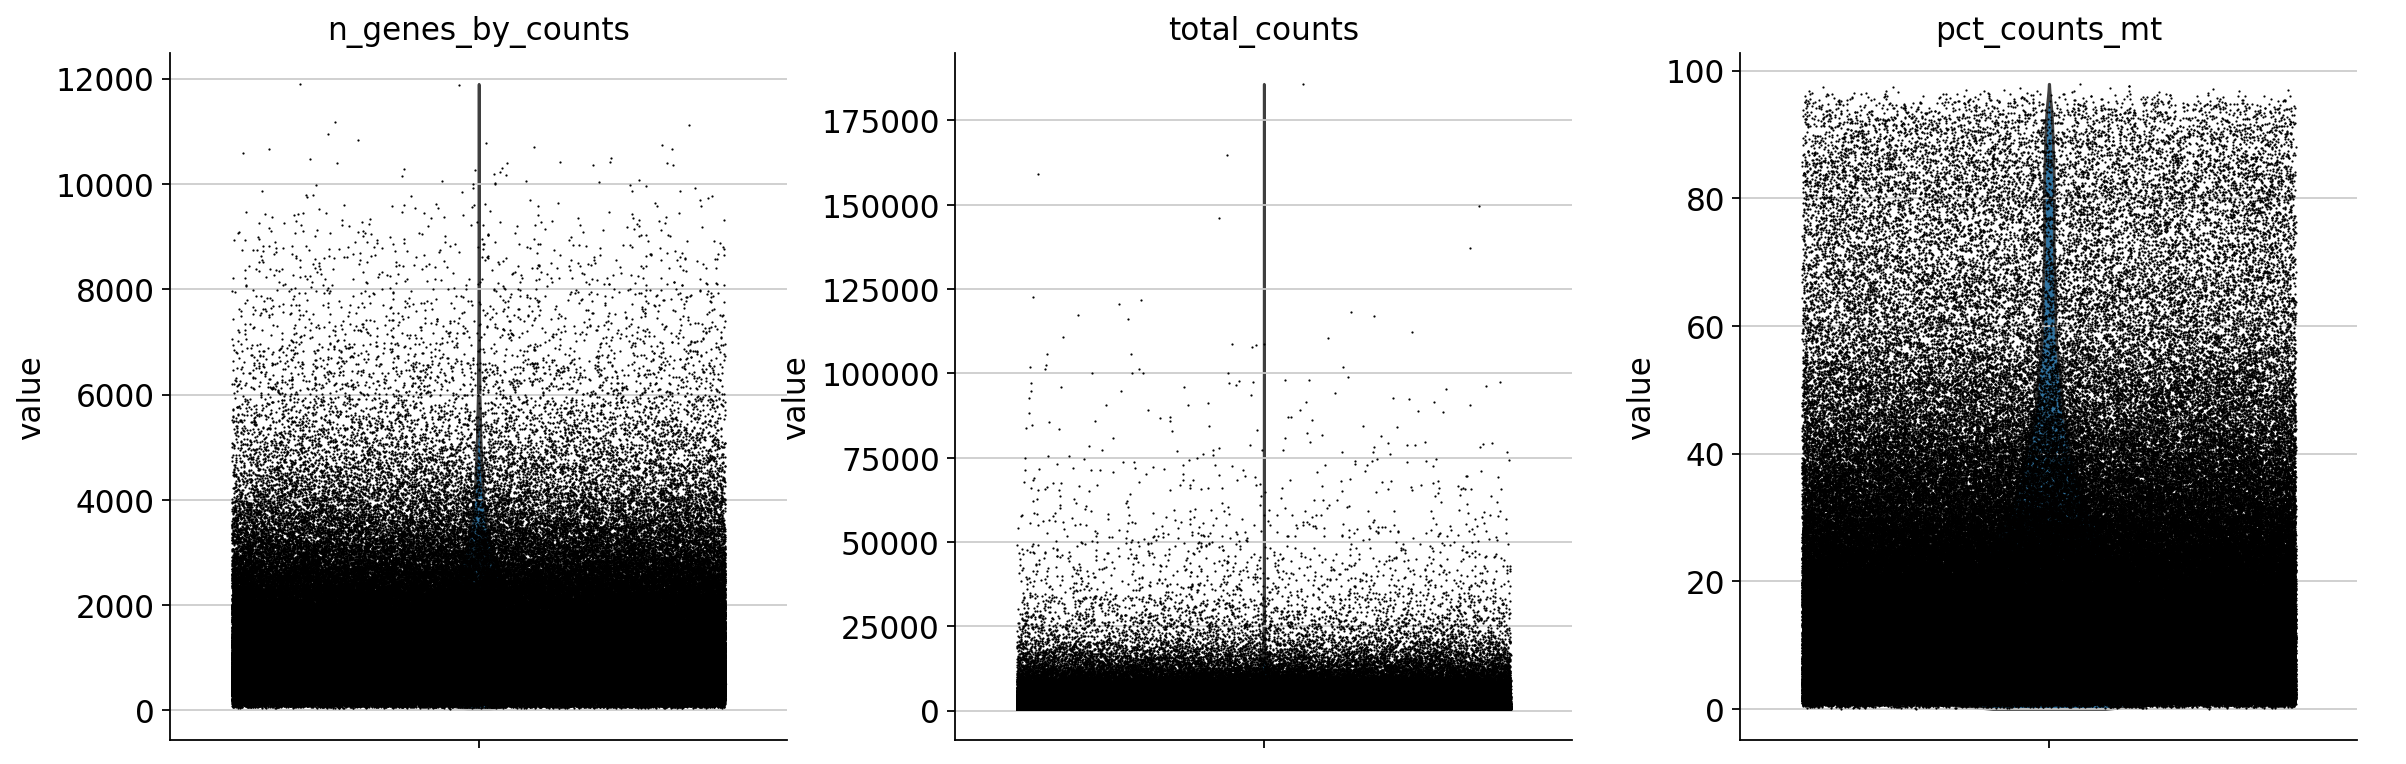

In [17]:
sc.pl.violin(
    merged_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True)

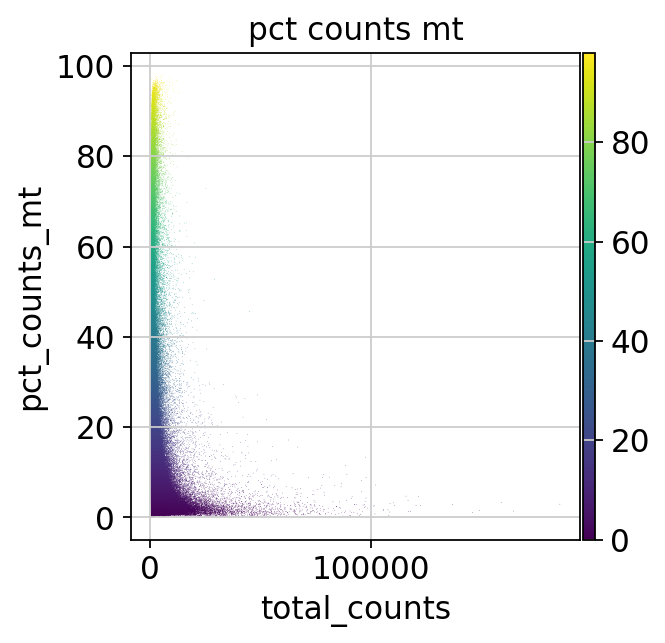

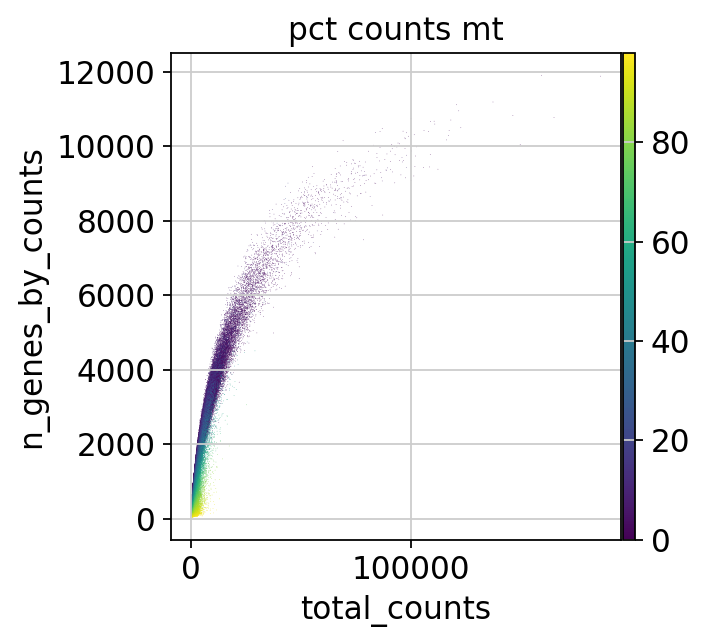

In [18]:
sc.pl.scatter(merged_adata, x="total_counts", y="pct_counts_mt", color="pct_counts_mt")
sc.pl.scatter(merged_adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_mt")

### **Outlier Threshold**

#### ***MAD = median(|Xi - median(X)|)***
Xi is the respective QC metric of an observation and 
describes a robust statistic of the variability of the metric.
[Germain et al., 2020]

In [19]:
#def is_outlier(merged_adata, metric: str, nmads: int):
#    M = merged_adata.obs[metric]
#    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
#        np.median(M) + nmads * median_abs_deviation(M) < M
#    )
#    return outlier

In [20]:
#merged_adata.obs["outlier"] = (
#    is_outlier(merged_adata, "log1p_total_counts", 5) |
#    is_outlier(merged_adata, "log1p_n_genes_by_counts", 5) #|
#    #is_outlier(merged_adata, "pct_counts_in_top_20_genes", 5)    
#)
#merged_adata.obs.outlier.value_counts()

In [21]:
#merged_adata.obs["mt_outlier"] = is_outlier(merged_adata, "pct_counts_mt", 3) | (
#    merged_adata.obs["pct_counts_mt"] > 20
#)
#merged_adata.obs.mt_outlier.value_counts()

In [22]:
#print(f"Total number of cells: {merged_adata.n_obs}")
#merged_adata = merged_adata[(~merged_adata.obs.outlier) & (~merged_adata.obs.mt_outlier)].copy()
#
#print(f"Number of cells after filtering of low quality cells: {merged_adata.n_obs}")

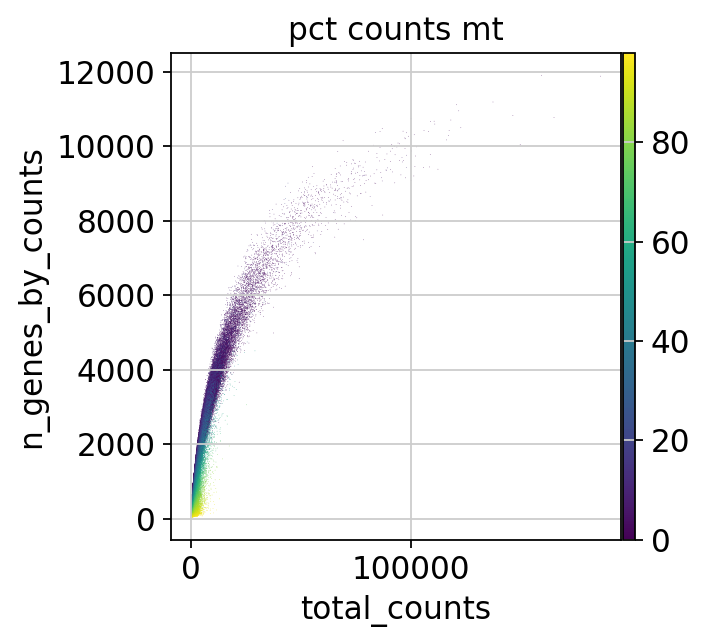

In [23]:
sc.pl.scatter(merged_adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_mt")

### **Filtering**

In [24]:
merged_adata

AnnData object with n_obs × n_vars = 385357 × 33538
    obs: 'Patient', 'Type', 'Sex', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts'

In [25]:
#print(f"Total number of genes: {merged_adata.n_vars}")
#rsc.pp.filter_cells(merged_adata, min_count=3)
#rsc.pp.filter_cells(merged_adata, max_count=20000)
#print(f"Number of genes after cell filter: {merged_adata.n_vars}")


merged_adata = merged_adata[merged_adata.obs.pct_counts_mt < 20, :]
merged_adata = merged_adata[merged_adata.obs.n_genes_by_counts < 5000, :]
merged_adata = merged_adata[merged_adata.obs.n_genes_by_counts > 200, :]

In [26]:
rsc.pp.filter_genes(merged_adata, min_count=3)

filtered out 4123 genes based on n_cells_by_counts


In [27]:
merged_adata

AnnData object with n_obs × n_vars = 267550 × 29415
    obs: 'Patient', 'Type', 'Sex', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts'

### **Plot after filtering**

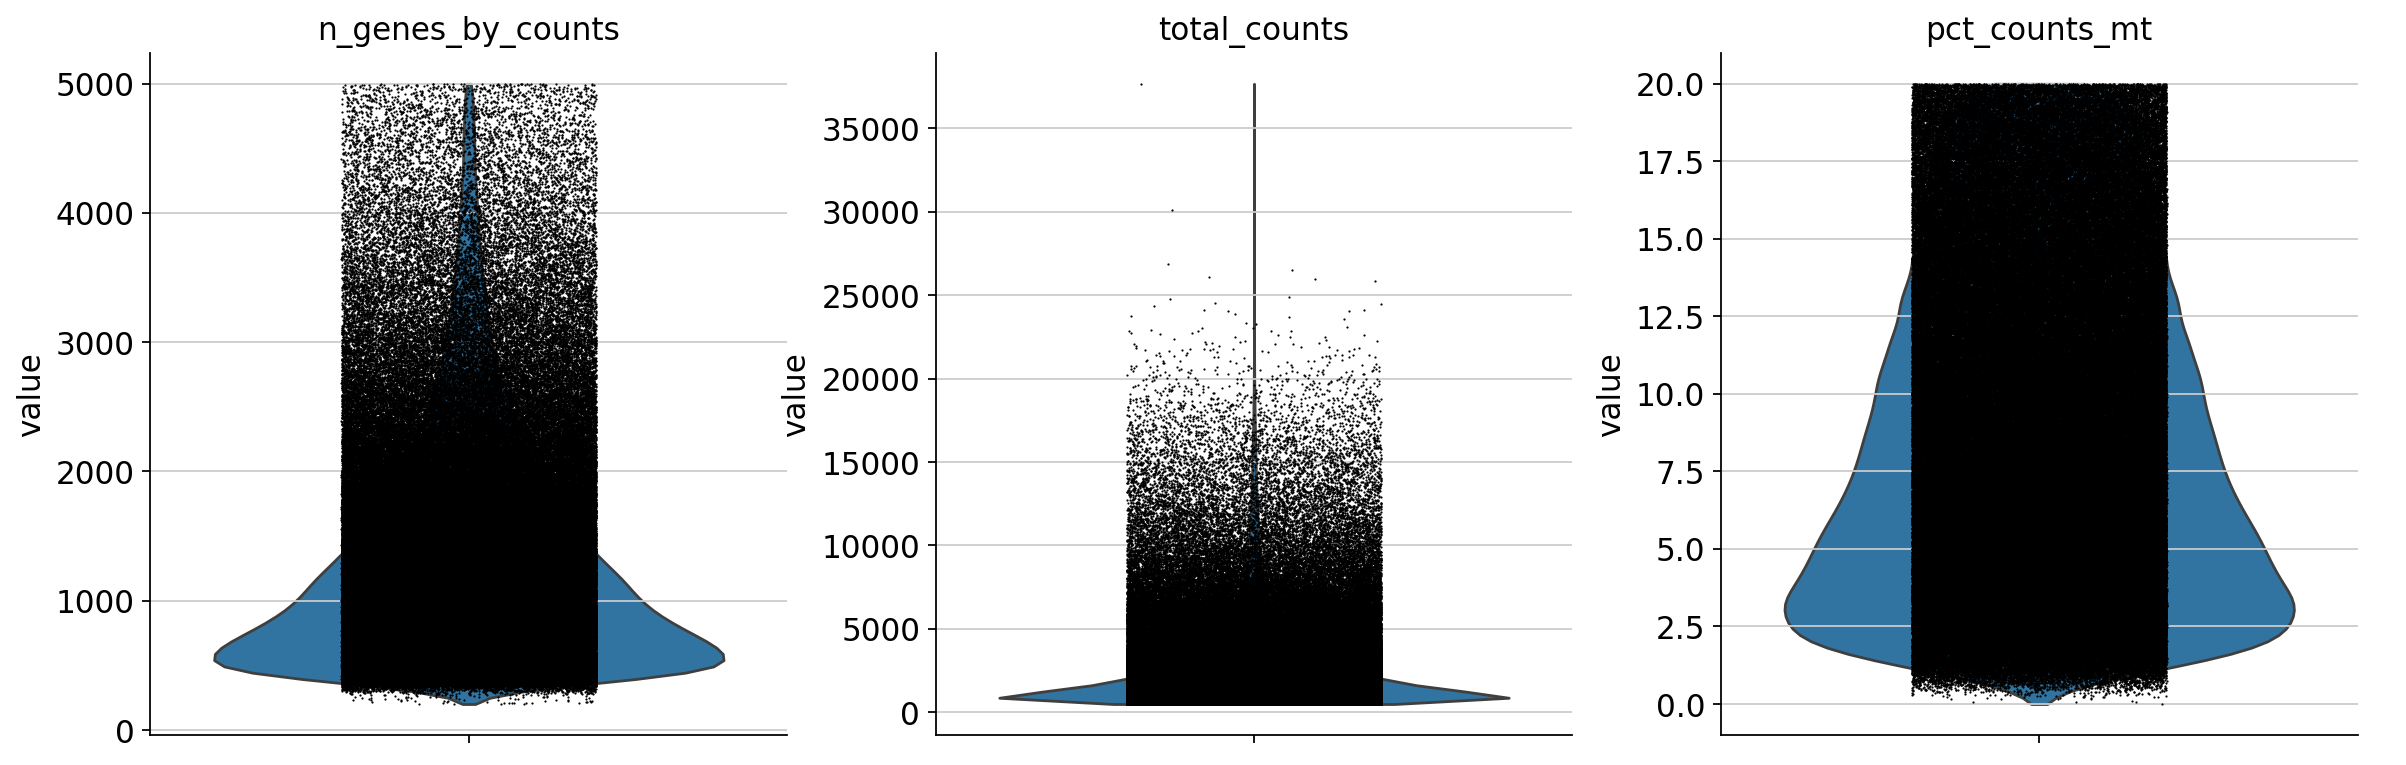

In [28]:
sc.pl.violin(
    merged_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.2,
    multi_panel=True)

In [29]:
merged_adata.layers["counts"] = merged_adata.X.copy()
merged_adata.shape

(267550, 29415)

## **Normalization**

In [30]:
rsc.pp.normalize_total(merged_adata, target_sum=1e4)

In [31]:
rsc.pp.log1p(merged_adata)

In [32]:
rsc.pp.highly_variable_genes(merged_adata, n_top_genes=5000, flavor="seurat_v3", layer = "counts")


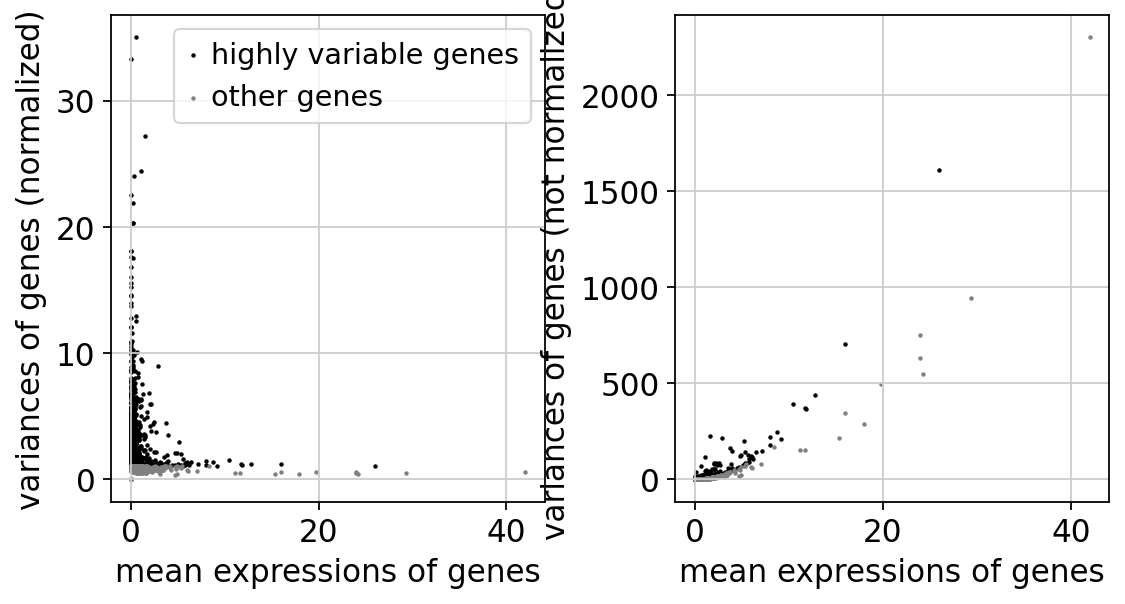

In [33]:
sc.pl.highly_variable_genes(merged_adata)

### Create .raw file

In [34]:
merged_adata.raw = merged_adata

In [35]:
merged_adata = merged_adata[:, merged_adata.var.highly_variable]

## **Regress out unwanted variable**

In [36]:
rsc.pp.regress_out(merged_adata, keys=["total_counts", "pct_counts_mt"])

## **Scale Data**

In [37]:
rsc.pp.scale(merged_adata, max_value=10)

## **Plot PCA**

In [38]:
rsc.pp.pca(merged_adata, n_comps=100)

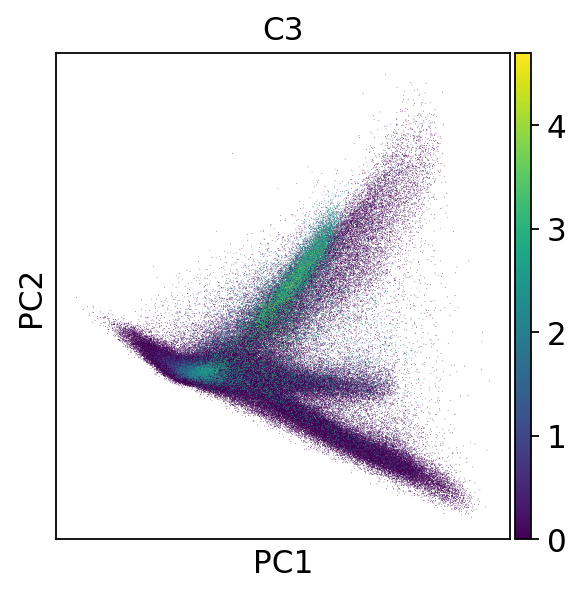

In [39]:
sc.pl.pca(merged_adata, color="C3")

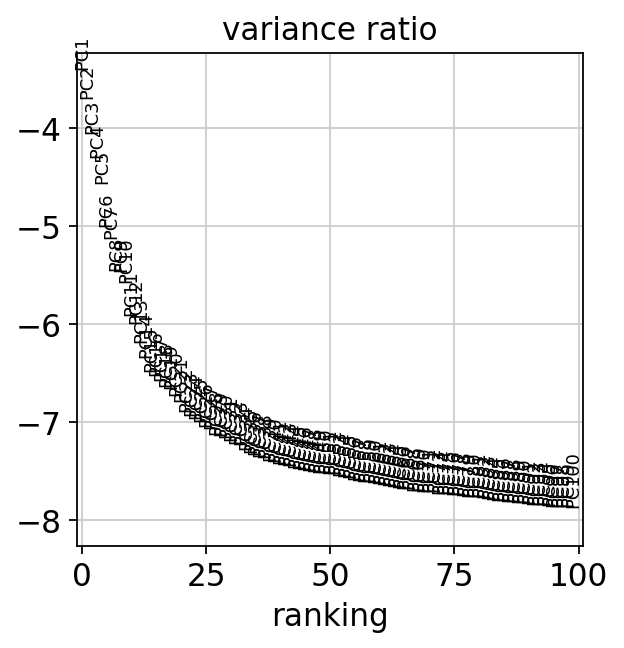

In [40]:
sc.pl.pca_variance_ratio(merged_adata, log=True, n_pcs=100)

In [41]:
rsc.get.anndata_to_CPU(merged_adata, convert_all=True)

In [42]:
merged_adata.write(results_file)

### **Batch Correction**

In [43]:
rsc.pp.harmony_integrate(merged_adata, key="Patient")

2024-03-19 16:44:42,585 - harmonypy_gpu - INFO - Iteration 1 of 10
2024-03-19 16:45:07,723 - harmonypy_gpu - INFO - Iteration 2 of 10
2024-03-19 16:45:33,173 - harmonypy_gpu - INFO - Iteration 3 of 10
2024-03-19 16:45:57,416 - harmonypy_gpu - INFO - Iteration 4 of 10
2024-03-19 16:46:10,759 - harmonypy_gpu - INFO - Iteration 5 of 10
2024-03-19 16:46:24,790 - harmonypy_gpu - INFO - Iteration 6 of 10
2024-03-19 16:46:36,079 - harmonypy_gpu - INFO - Iteration 7 of 10
2024-03-19 16:46:49,238 - harmonypy_gpu - INFO - Iteration 8 of 10
2024-03-19 16:47:00,474 - harmonypy_gpu - INFO - Iteration 9 of 10
2024-03-19 16:47:24,849 - harmonypy_gpu - INFO - Iteration 10 of 10
2024-03-19 16:47:42,881 - harmonypy_gpu - INFO - Stopped before convergence


## **Find Neighbors**

In [44]:
rsc.pp.neighbors(merged_adata, n_neighbors=15, n_pcs=50)

In [62]:
rsc.tl.umap(merged_adata)
rsc.tl.tsne(merged_adata, n_pcs=40)


[W] [16:51:45.890694] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


## **Clustering and Visualization**

In [63]:
rsc.tl.leiden(merged_adata, resolution=1)
rsc.tl.louvain(merged_adata, resolution=0.6)

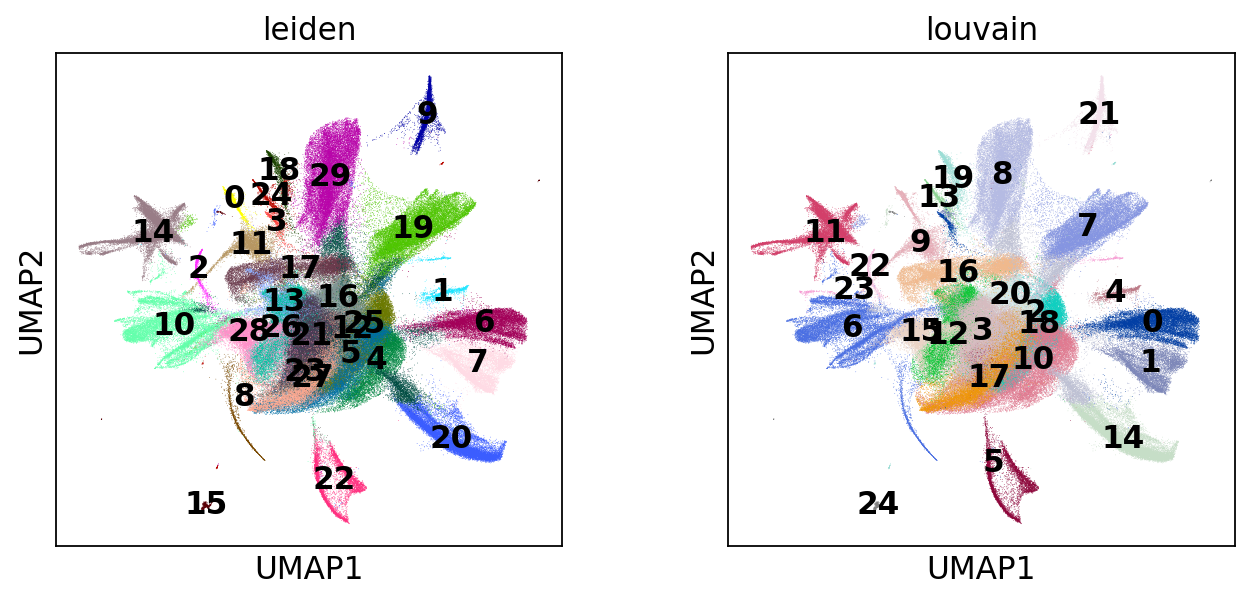

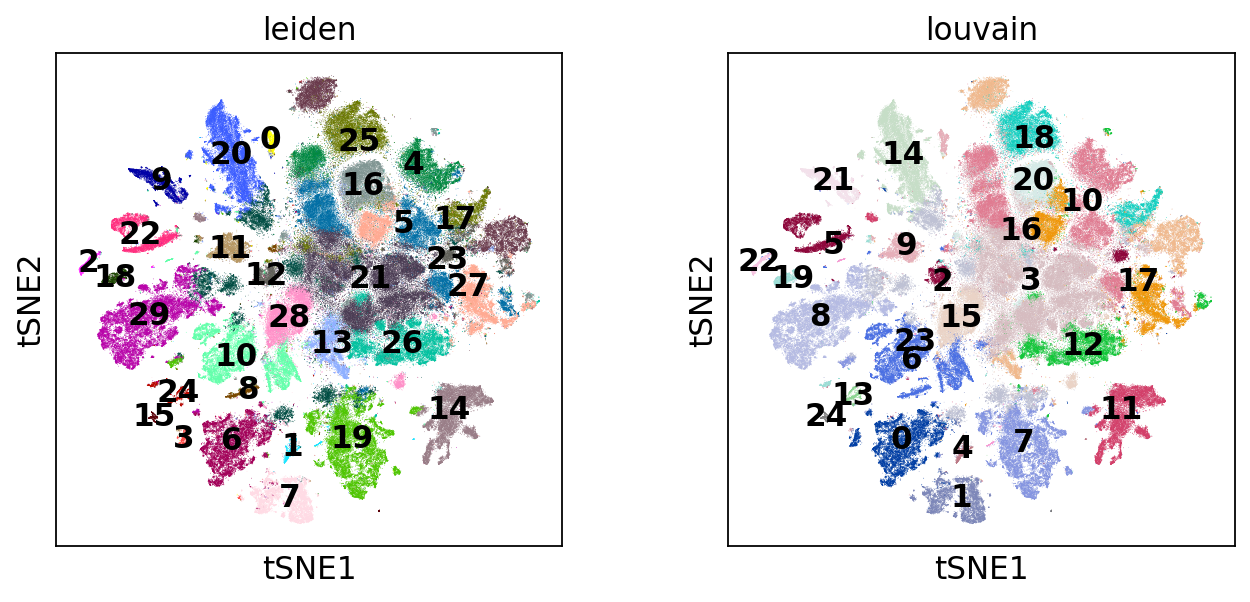

In [64]:
sc.pl.umap(merged_adata, color=["leiden", "louvain"], legend_loc="on data")
sc.pl.tsne(merged_adata, color=["leiden", "louvain"], legend_loc="on data")

In [65]:
merged_adata.write(results_file)

### UMAP and TSNE with Kmeans

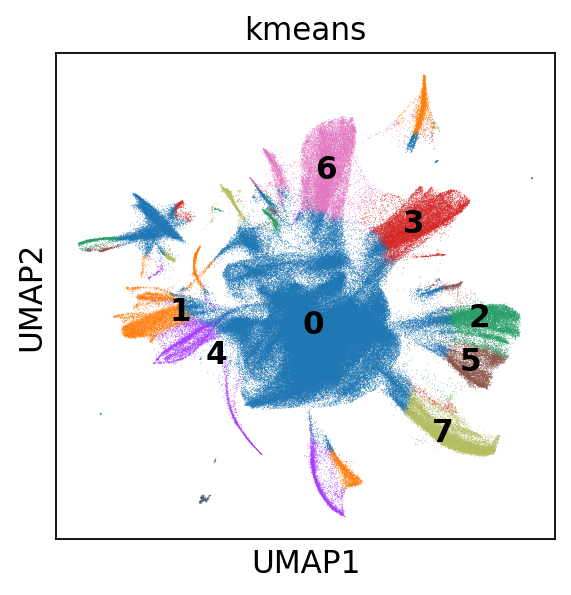

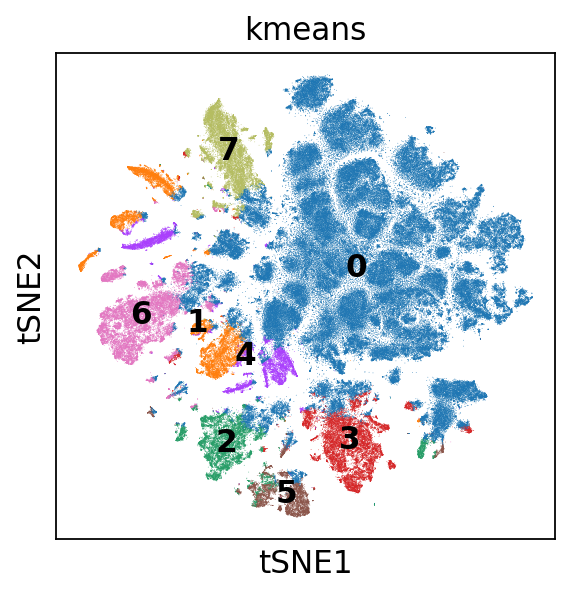

In [66]:
rsc.tl.kmeans(merged_adata, n_clusters=8)

sc.pl.umap(merged_adata, color=["kmeans"], legend_loc = 'on data')
sc.pl.tsne(merged_adata, color=["kmeans"], legend_loc = 'on data')

### Embedding density in the UMAP

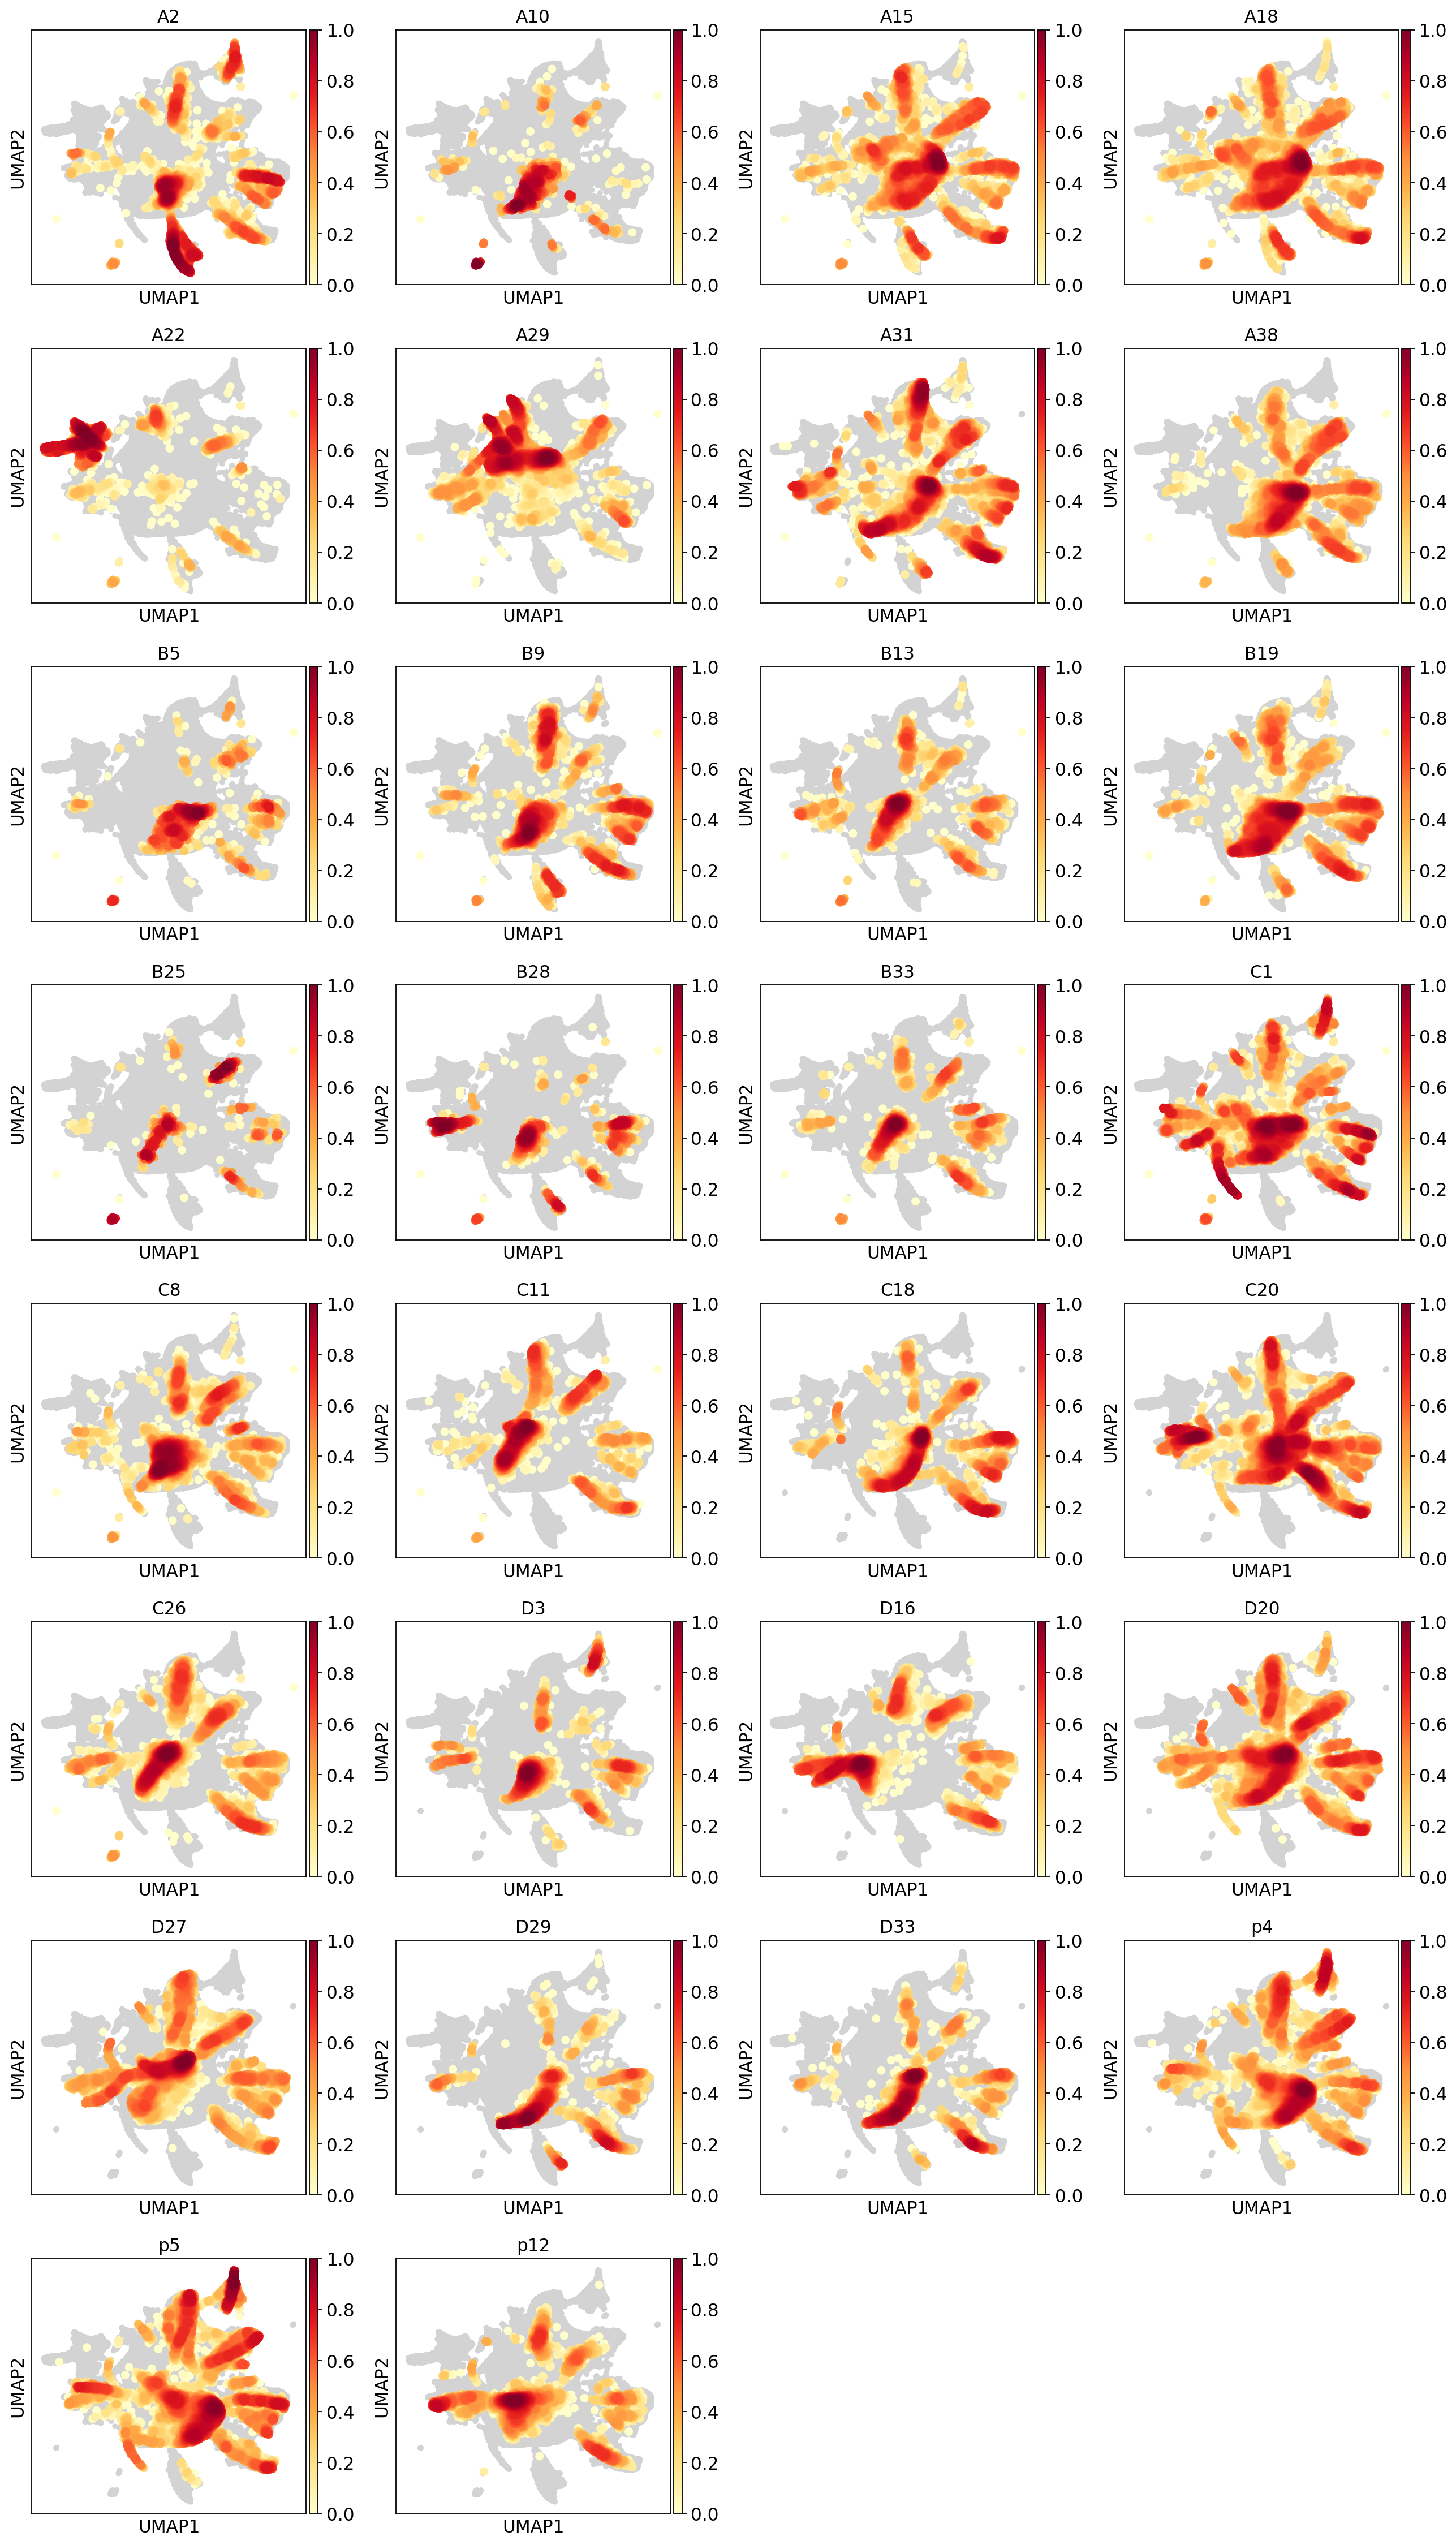

In [67]:
rsc.tl.embedding_density(merged_adata, groupby="Patient")
sc.pl.embedding_density(merged_adata, groupby="Patient")

## **DE analysis**

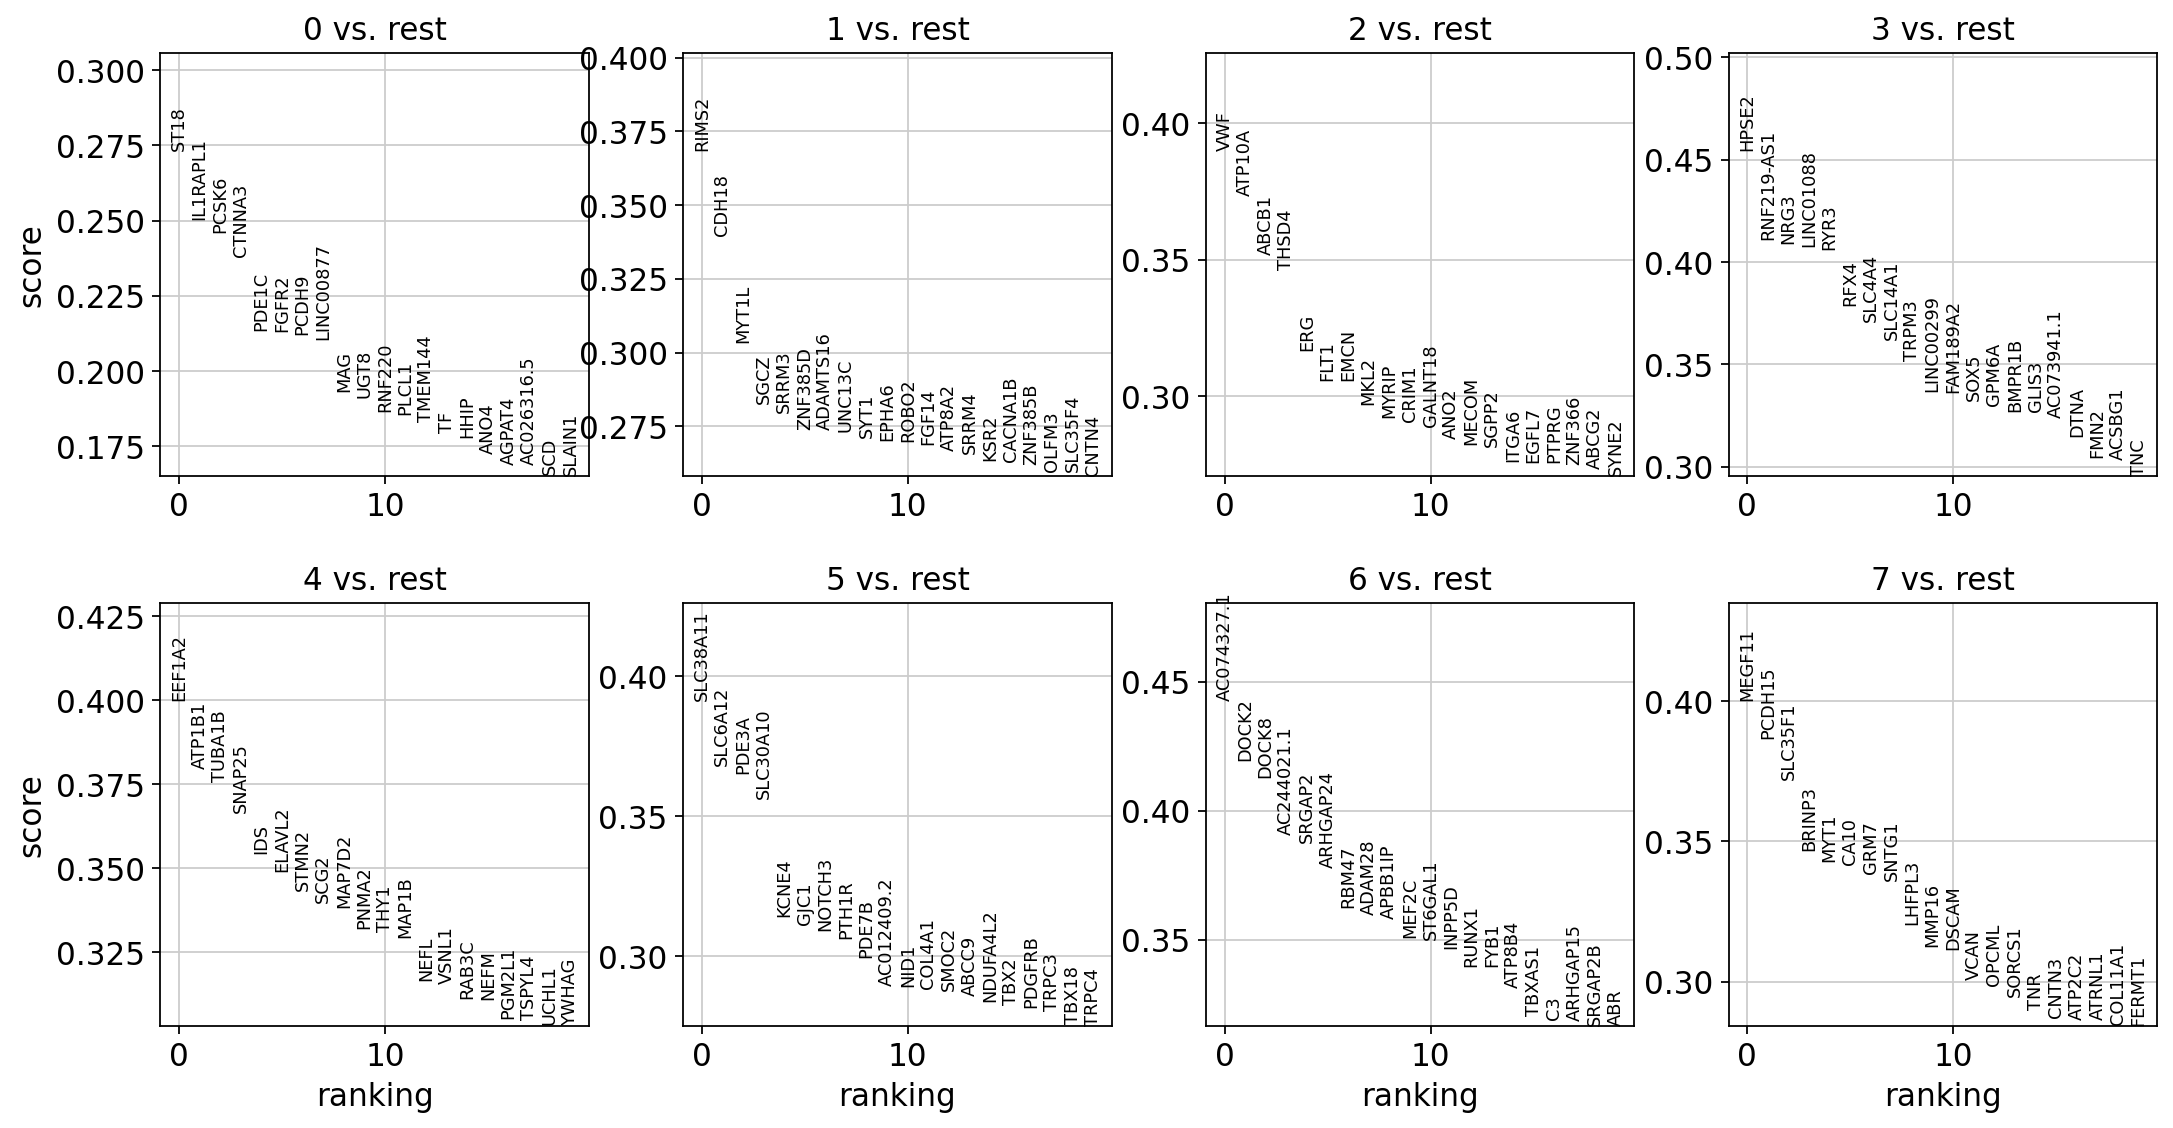

In [68]:
# Methods can be 't-test', 't-test_overestim_var' for overreestimates varience of each group
# 'wilcoxon' for rank-sum
# 'logreg' for logistic regression

rsc.tl.rank_genes_groups_logreg(merged_adata, groupby="kmeans", use_raw=False)
sc.pl.rank_genes_groups(merged_adata, n_genes=20, sharey=False, ncols=4)

In [69]:
sc.settings.verbosity = 2  # reduce the verbosity
merged_adata.write(results_file)

In [70]:
#sc.tl.rank_genes_groups(merged_adata, "leiden", method="wilcoxon")
#sc.pl.rank_genes_groups(merged_adata, n_genes=25, sharey=False, ncols=4)

In [71]:
#sc.tl.rank_genes_groups(merged_adata, "leiden", method="logreg", max_iter=1000)
#sc.pl.rank_genes_groups(merged_adata, n_genes=25, sharey=False, ncols=4)

In [72]:
merged_adata = sc.read(results_file)

In [73]:
pd.DataFrame(merged_adata.uns["rank_genes_groups"]["names"]).head(10)

0         1       2           3       4           5           6  \
0       ST18     RIMS2     VWF       HPSE2  EEF1A2    SLC38A11  AC074327.1   
1   IL1RAPL1     CDH18  ATP10A  RNF219-AS1  ATP1B1     SLC6A12       DOCK2   
2      PCSK6     MYT1L   ABCB1        NRG3  TUBA1B       PDE3A       DOCK8   
3     CTNNA3      SGCZ   THSD4   LINC01088  SNAP25    SLC30A10  AC244021.1   
4      PDE1C     SRRM3     ERG        RYR3     IDS       KCNE4      SRGAP2   
5      FGFR2   ZNF385D    FLT1        RFX4  ELAVL2        GJC1    ARHGAP24   
6      PCDH9  ADAMTS16    EMCN      SLC4A4   STMN2      NOTCH3       RBM47   
7  LINC00877    UNC13C    MKL2     SLC14A1    SCG2       PTH1R      ADAM28   
8        MAG      SYT1   MYRIP       TRPM3  MAP7D2       PDE7B     APBB1IP   
9       UGT8     EPHA6   CRIM1   LINC00299   PNMA2  AC012409.2       MEF2C   

         7  
0   MEGF11  
1   PCDH15  
2  SLC35F1  
3   BRINP3  
4     MYT1  
5     CA10  
6     GRM7  
7    SNTG1  
8   LHFPL3  
9    MMP16

In [74]:
#result = merged_adata.uns["rank_genes_groups"]
#groups = result["names"].dtype.names
#pd.DataFrame(
#    {
#        group + "_" + key[:1]: result[key][group]
#        for group in groups
#        for key in ["names", "pvals"]
#    }
#).head(10)

In [75]:
#sc.tl.rank_genes_groups(merged_adata, "leiden", groups=["3"], reference="15", method="wilcoxon")
#sc.pl.rank_genes_groups(merged_adata, groups=["3"], n_genes=20)

In [76]:
#merged_adata = sc.read(results_file)

In [77]:
#sc.pl.rank_genes_groups_violin(merged_adata, groups="3", n_genes=8)

In [78]:
#sc.pl.violin(merged_adata, ["C3", "P2RY12"], groupby= "leiden", use_raw=False)